<a href="https://colab.research.google.com/github/yoitsyoung/EC1B1/blob/main/EC2B1_LT_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EC2B1 2023 

We characterize long-run economic developments in **Japan** and **Peru**, discuss the reasons behind them, and compare the two countries.

In [4]:
#import necessary libraroes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We first define the functions we will use in our notebook


In [5]:
# define get_regression_coefs
def get_regression_coefs(Y, x1, x2, x3=None):
    """
    Compute coefficients for trend regressions.

    Given a vector `Y` and a collection of regressors `*args`, return vector of coefficients `coefs`.

    Parameters
    ----------
    Y : (T,) array that will be the dependent variable. In our example, either GDP per capita in
    level or in logs.
    
    *args : N arrays of dimension (T,) that are the regressors. For example, the first array will be
    a (T,) array with elements of ones. 
    
    Note: *args is a convenient Python command to flexibly allow
    for different number of inputs into a function. That is, `get_regression_coefs(Y, x1, x2)` will
    give us args = `(x1, x2)` while `get_regression_coefs(Y, x1, x2, x3)` will give us args = `(x1,
    x2, x3)`. This allows us to use the same function for all different specifications.

    Returns
    -------
    coefs: This returns the array of coefficients. If we input two regressors (i.e. `x1` and `x2`),
    then coefs = `(a, b)`. If we input three regressors (i.e. `x1`, `x2`, and `x3`), then coefs =
    `(a, b1, b2)`. Ordering `x1` as the vector of ones ensures that `a` is the intercept.
    """
    
    T = len(Y) # The first element of args is x1. Its length should correspond to the number of time periods T in the sample.
    if x3 is None:
        X = np.concatenate((x1[:, None], x2[:, None]), axis = 1)	
    else:
        X = np.concatenate((x1[:, None], x2[:, None], x3[:, None]), axis=1)
    

    # N = len(args) # The number of elements specified in *args corresponds to the number of inputs (i.e. if run `get_regression_coefs(Y, x1, x2)', then N = 2)

    # X = np.empty((T, N)) # initialise the X data

    # # in a for loop iterate through our regressors *args and fill in the X data
    # for ix in range(N):
    #     x = args[ix] # extract our input array, i.e. for ix = 0 this will be x1 and our vector of ones
    #     X[:, ix] = x # fill the X data with our input arrays

    #     # Note: for a more elegant and more Pythonian solution see the enumerate() function.

    XX = X.T @ X # Construct X'X
    XY = X.T @ Y # Construct X'Y

    coefs = np.linalg.inv(XX) @ XY # solve for formula (X'X)^(-1) X'Y

    # Congratulations we just ran a regression.
    return coefs

In [6]:

def model_country_time_trend(data, COUNTRY):
    #slice data to obtain only the data relevant to the country we are analyzing
    data = data.loc[data["country"] == COUNTRY, ("year", "rgdpna", "rgdpna_pc", "emp", "rnna", "hc", "ctfp")]

    #Did not include ymin and ymax here since we are taking the entire time series
    data = data.reset_index(drop = True)

    # We use logical indexing to subset the data to RGDP per capita time series only
    Y = data.loc[:,"rgdpna_pc"]
    y = np.log(Y)
    
    T = len(data) # sample size used for regression
    T_all = data["year"].max() - (data["year"].min() - 1) # Because we are using the entire time series, T should equal T_all
    
    # Compute different trend specifications
    """
    We will now compute four different specifications: (i) additive + linear (ii) additive + quadratic
    (iii) exponential + linear and (iv) exponential + quadratic.

    We will not do anything extraordinary, but simply run a linear regression. In Stata, you would run
    `reg y x1 x2`. In R, you would run `lm(formula = y ~ x1 + x2, data)`. We will run
    `get_regression_coefs(y, x1, x2)` in Python. 
    """

    # 3.1) Additive Models
    # 3.1.1) Additive, Linear Model
    # First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
    # The dependent variable is per capita GDP in *levels*

    x1 = np.empty(T) # initialise an empty vector for the first regressor
    x2 = np.empty(T) # initialise an empty vector for the second regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1 # recall that Python starts indexing at 0

    a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

    # Having computed the coefficients, we can now evaluate the trend for the entire time series,
    # i.e.also for years later than those used in the regression.

    # Initialise predicted values yhat
    Yhat_add_lin = np.empty(T_all)

    # Create loop to compute trend for all years
    for t in range(T_all):
        Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0

    # Let us convert into log-units
    yhat_add_lin = np.log(Yhat_add_lin)

    # 3.1.2) Additive, Quadratic Model
    # Let us repeat the above for a quadratic specification. Now we also need a third regressor with
    # values t**2 (which is t^2 in Python)
    # What will be the dependent variable for the additive model?

    x1, x2, x3 = np.empty(T), np.empty(T), np.empty(T)
    # same as x1 = np.empty(T); x2 = np.empty(T); x3 = np.empty(T) all in separate lines
    # even more elegant: x1, x2, x3 = [np.empty(T) for j in range(3)]

    # Create loop to construct vector of regressors
    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1
        x3[t] = (t + 1)**2

    a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)

    # Initialise predicted values yhat
    Yhat_add_quad = np.empty(T_all)

    # Create loop to compute trend for all years
    for t in range(T_all):
        Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1)**2 

    # Let us convert into log-units
    yhat_add_quad = np.log(Yhat_add_quad)

    # 3.2) Exponential Model
    # Independent variables are exactly as before. Which dependent variable will we use? Be careful
    # about the scaling of units!

    # 3.2.1) Exponential, Linear Model
    x1, x2 = np.empty(T), np.empty(T) # initialise an empty vector for the first regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1 # recall that Python starts indexing at 0

    a_exp_lin, b_exp_lin = get_regression_coefs(y, x1, x2)

    # Initialise predicted values yhat
    yhat_exp_lin = np.empty(T_all)

    # Create loop to compute trend for all years
    for t in range(T_all):
        yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1) # recall that Python indexing starts at 0

    # 3.2.2) Exponential, Quadratic model
    # Repeat above for quadratic specification
    x1, x2, x3 = np.empty(T), np.empty(T), np.empty(T) # initialise an empty vector for the first regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1
        x3[t] = (t + 1)**2

    a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y, x1, x2, x3)

    # Initialise predicted values yhat
    yhat_exp_quad = np.empty(T_all)

    # Create loop to compute trend for all years
    for t in range(T_all):
        yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1)**2

    lw = 4

    # Plot by additive and exponential
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    ax1.plot(data['year'], np.log(data['rgdpna_pc']), linewidth = lw)
    ax1.plot(data['year'], yhat_add_lin, linewidth = lw, linestyle = 'dashed', label = 'Linear fit')
    ax1.plot(data['year'], yhat_add_quad, linewidth = lw, linestyle = 'dotted', label = 'Quadratic fit')
    ax1.set_ylabel(r'$\log(Y_t)$')
    ax1.set_title('Additive Model')
    ax1.legend()

    ax2.plot(data['year'], np.log(data['rgdpna_pc']), linewidth = lw)
    ax2.plot(data['year'], yhat_exp_lin, linewidth = lw, linestyle = 'dashed', label = 'Linear fit')
    ax2.plot(data['year'], yhat_exp_quad, linewidth = lw, linestyle = 'dotted', label = 'Quadratic fit')
    ax2.set_ylabel(r'$\log(Y_t)$')
    ax2.set_title('Exponential Model')
    ax2.legend()


Next, we import our dataset, perform some cleaning, and plot graphs for country growth trends. 

In [7]:
# 2.1) Load dataset. Load dataset from github into a notebook which can be run on Google Colab
SOURCE_FILE = "https://github.com/yoitsyoung/EC1B1/blob/main/pwt100.xlsx?raw=true"
data = pd.read_excel(SOURCE_FILE, sheet_name = 'Data', header = 0)

# 2.2) Clean data
# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpna", "pop", "emp", "rnna", "hc", "ctfp")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]

<ipython-input-6-3057d1db55ba>:77: RuntimeWarning: invalid value encountered in log
  yhat_add_quad = np.log(Yhat_add_quad)


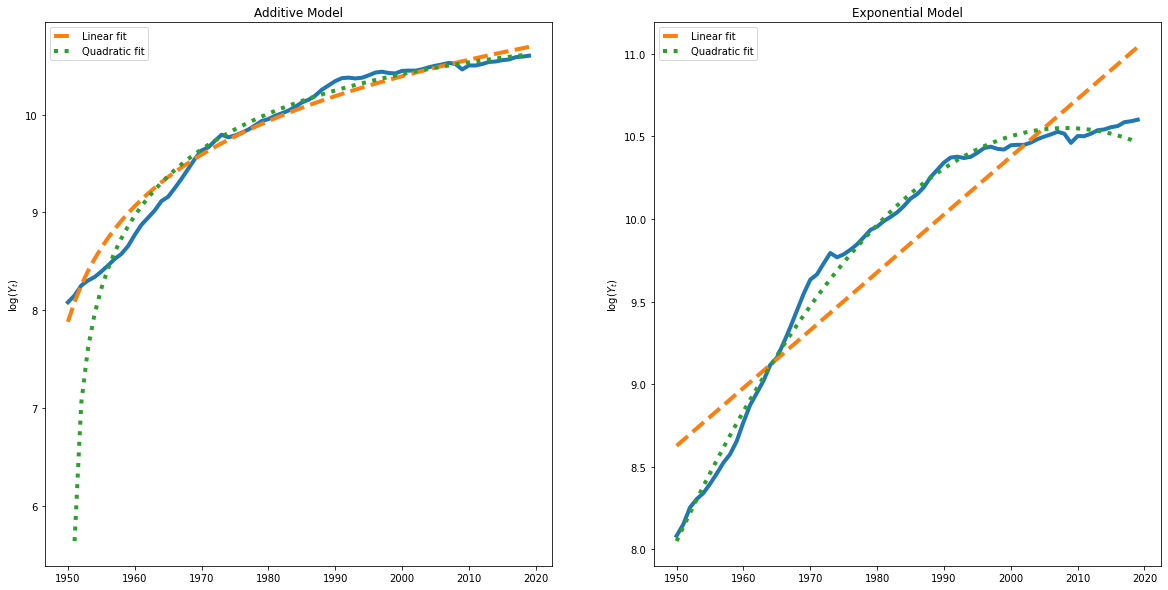

In [8]:
model_country_time_trend(data, "Japan")

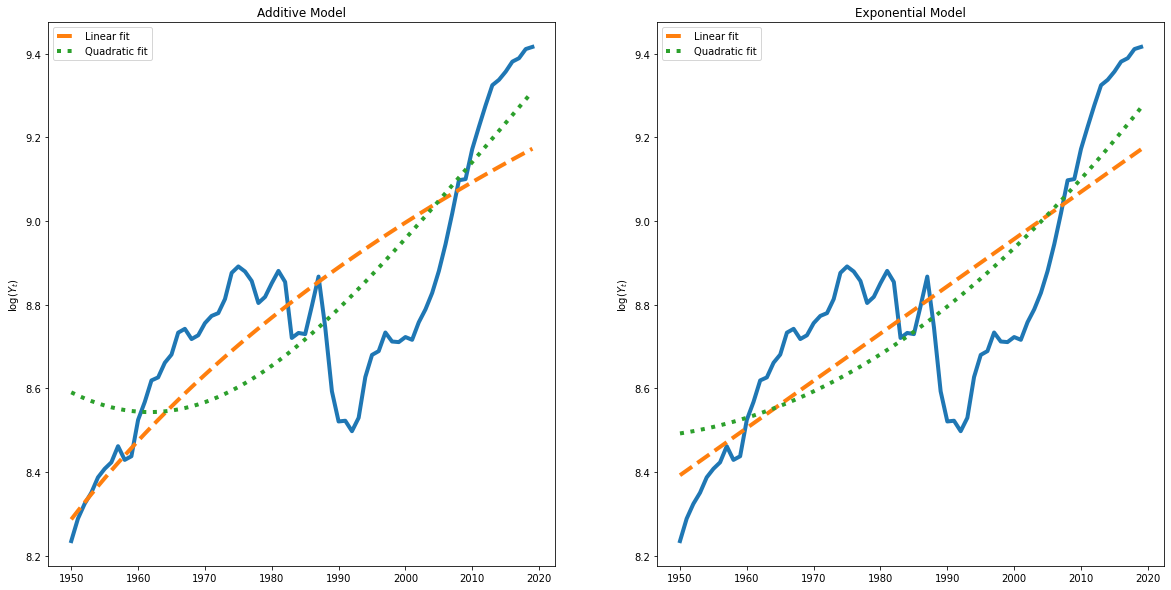

In [9]:
model_country_time_trend(data, "Peru")


### Documenting Empirical Observations
GDP for Japan was mostly increasing from 1950 - 2020, though the rate of increase was lower nearing the end of 2020. GDP growth in Japan is best modelled by a quadratic fit which allows for the rate of GDP growth to increase or decrease. 

GDP for Peru grew from 1950 - 1970, before beginning to decline until 1992. Peru then grew its GDP from 1992 till today. Peru's GDP increased from 1950 - 2020 overall. GDP growth in Peru is best modelled by a quadratic fit, but there are still relatively large differences between predicted values in the model and actual GDP values. A cubic function might thus be needed to model the rise, fall, and rise in GDP of Peru. 

### Growth Accounting

Growth accounting is a procedure used in economics to measure the contribution of different factors to economic growth and to indirectly compute the rate of technological progress, measured as a residual, in an economy. 

**Total Factor Productivity** gives us a quantitative measure of how effective factors of production are converted to output (Weil, Chpt 7).
Under the production function, $Y = A  K^{\alpha}L ^{1-\alpha}$ (Solow, 1956), we take logs to both side to get $d \log(Y) = d \log(A) + \alpha d \log(K) + ({1-\alpha})d \log(L) $. 

Also, since $\log(1+x) \approx x$ such that $\log(Y_{t+1}) - \log(Y_t) = \log(Y_{t+1} / Y_{t}) = \log(1 +
(Y_{t+1}-Y_t) / Y_{t}) \approx \frac{Y_{t+1}-Y_t}{Y_t}$, we thus know that $d\log(Y)$ is approximately the
growth rate of $Y$.

We first reverse engineer the value of TFP (A) via equation $A = (\frac{Y }{K^{\alpha} L ^{1-\alpha}}) $
Using the above, we can compute the contribution of each factor to growth as $d \log(A) / d \log(Y)$,  $({1-\alpha})d \log(L) / d \log(Y)$, and $\alpha d \log(K) / d\log(Y)$, respectively. (Young, 1992)

**Alpha** represents capital's share of income. We use 0.33 as our value for Alpha because it is generally estimated as such in economic literature (Weil, 2013). 

We do not obtain a value of TFP by running an OLS regression on the time series as we will run into the problem of endogeniety amongst K and L values across time. We will also face the problem of autocorrelation of errors, leading to MLR assumptions not holding.

Now, we define our python function for growth accounting:



In [10]:

def find_growth_contribution(data, COUNTRY, ALPHA):

    data = data.loc[data["country"] == COUNTRY, ("year", "rgdpna", "rgdpna_pc", "emp", "rnna", "hc", "ctfp")]
    data = data.reset_index(drop = True)
    data_copy = data
    #Reverse engineer value of TFP (A) Using the Romer Production function
    A = np.divide(data["rgdpna"],np.multiply(data["rnna"]**ALPHA,data["emp"]**(1-ALPHA)))
    data_copy["TFP"] = A
    list_of_columns = [data["rgdpna"],data["TFP"], data["rnna"], data["emp"]]
    names_of_columns = ["GDP", "TFP", "Capital", "Labour" ]
    fig, axs = plt.subplots(2, 4, figsize = (30, 15))
    for i in range(0,4): 
      axs[0][i].plot(data_copy["year"] , np.log(list_of_columns[i]))
      axs[0][i].set_xlabel("Year")
      axs[0][i].set_ylabel("Log Values of " + names_of_columns[i])
      axs[0][i].set_title(COUNTRY)
    for i in range(0,4): 
      axs[1][i].plot(data_copy["year"] , list_of_columns[i])
      axs[1][i].set_xlabel("Year")
      axs[1][i].set_ylabel("Absolute Values of " + names_of_columns[i])
      axs[1][i].set_title(COUNTRY)

  
    plt.show()
    plt.figure(figsize=(20,10))
    plt.plot(data["emp"])

    #SANITY CHECK difference between ctfp in dataset and calculated values of A
    print("Difference between dataset CTFP and A values calculated")
    print((A - data["ctfp"]).describe())
    print(len(data))
    T = len(data)
    
    A_path = np.ones(T) * A # set path for TFP

    k_path = data["rnna"].to_numpy() # initialise array for time path of capital by indexing dataframe

    y_path = data["rgdpna"].to_numpy() # initialise array for time path of output by indexing dataframe

    l_path = data["emp"].to_numpy() # initialise array for time path of labour by indexing dataframe
    
    dlog_y = np.empty(T-1) # taking difference removes one observation effectively
    dlog_A = np.empty(T-1)
    dlog_k = np.empty(T-1)
    dlog_l = np.empty(T-1)

    for t in range(T-1):
        dlog_y[t] = np.log(y_path[t+1]) - np.log(y_path[t])
        dlog_A[t] = np.log(A_path[t+1]) - np.log(A_path[t])
        dlog_k[t] = np.log(k_path[t+1]) - np.log(k_path[t])
        dlog_l[t] = np.log(l_path[t+1]) - np.log(l_path[t])
        
    contr_TFP = dlog_A / dlog_y
    contr_k = ALPHA * dlog_k / dlog_y
    contr_l = (1-ALPHA) * dlog_l / dlog_y

    # Construct growth accounting table similar to Young (1992)
    data = {'Year': data["year"][1:],'Growth Y' : dlog_y, 'Growth TFP' : dlog_A,
            'Growth K' : dlog_k, 'Growth L' : dlog_l,
            'Contribution of TFP' : contr_TFP,
            'Contribution of K' : contr_k,
            'Contribution of L' : contr_l}
    # Construct the table as a pandas dataframe
    growth_table = pd.DataFrame(data = data)
    growth_table.index.name = "Time Period"

    
    plt.title(COUNTRY)
    plt.rcParams['font.size'] = "12"
    plt.figure(figsize=(20,10))
    width = 0.25
    plt.ylabel("Contribution to change in GDP")
    plt.xlabel("Year")
    plt.bar(data_copy["year"][1:], contr_TFP, width, label = "TFP")
    plt.bar(data_copy["year"][1:] + width, contr_k, width, label = "Capital")
    plt.bar(data_copy["year"][1:] + width*2, contr_l, width, label = "Labour")
    plt.legend()
    plt.show()

    fig, axs = plt.subplots(1,3, figsize = (30, 20), sharey=True)
    contr_list = [contr_TFP, contr_k, contr_l]
    growth_list = [ dlog_A, dlog_k, dlog_l, dlog_y]
    name_list = ["TFP", 'Capital', 'Labour', 'GDP']
    
    for i in range(0,3): 
      axs[i].plot(data_copy["year"][1:] , contr_list[i])
      axs[i].set_xlabel("Year")
      axs[i].set_ylabel("Contribution of " + name_list[i])
      axs[i].set_title(COUNTRY)

    plt.show()

    plt.figure(figsize=(20,10))
    for i in range(0,3): 
      plt.plot(data_copy["year"][1:] , contr_list[i], label = name_list[i])
    plt.title(COUNTRY)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Contribution of ")
    plt.show()
    plt.figure(figsize=(20,10))
    for i in range(0,4): 
      plt.plot(data_copy["year"][1:] , growth_list[i], label = name_list[i])
    plt.title(COUNTRY)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Growth of ")
    plt.show()

    #SANITY CHECK that contributions add up to 1
    print("SANITY CHECK that contributions add up to 1")
    print(contr_TFP + contr_k + contr_l)

    # Print table of growth contribution
    print("Growth Table")
    print(growth_table.to_string())
    # Print Averages
    print(growth_table.mean())

We graph the trends of TFP, Capital, and Labour and also the contribution of each factor to GDP over time

In [11]:
#Set a common value for Alpha. Note that the value of A is extremely sensitive to Alpha
ALPHA = 0.33

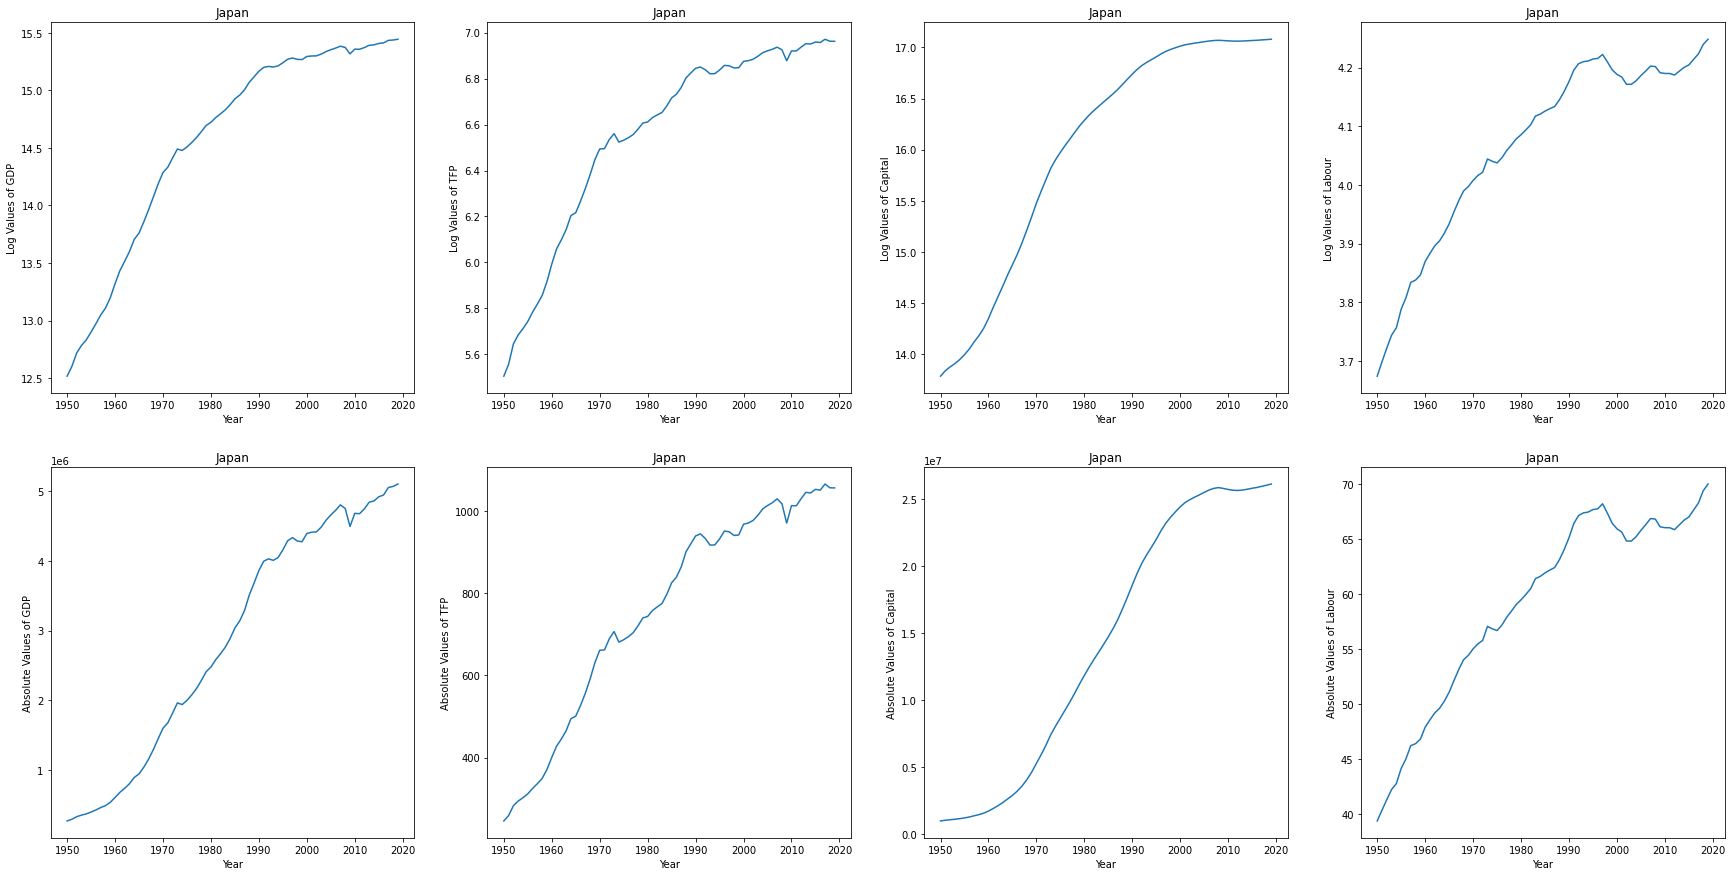

Difference between dataset CTFP and A values calculated
count      66.000000
mean      786.070240
std       233.570654
min       302.063715
25%       660.659148
50%       850.684407
75%       974.704865
max      1064.906572
dtype: float64
70


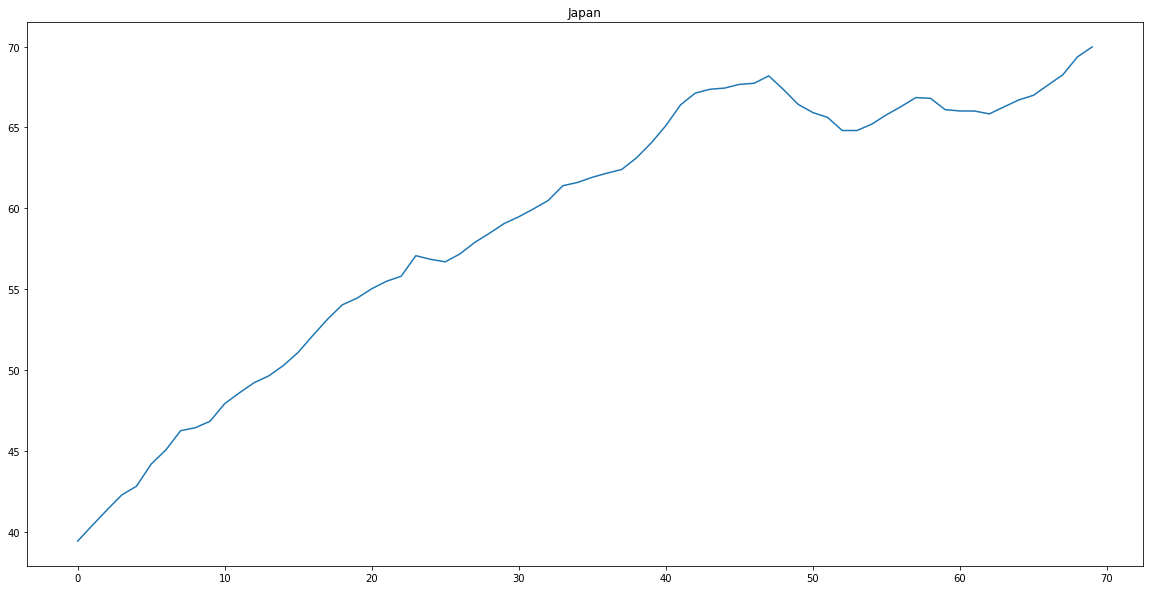

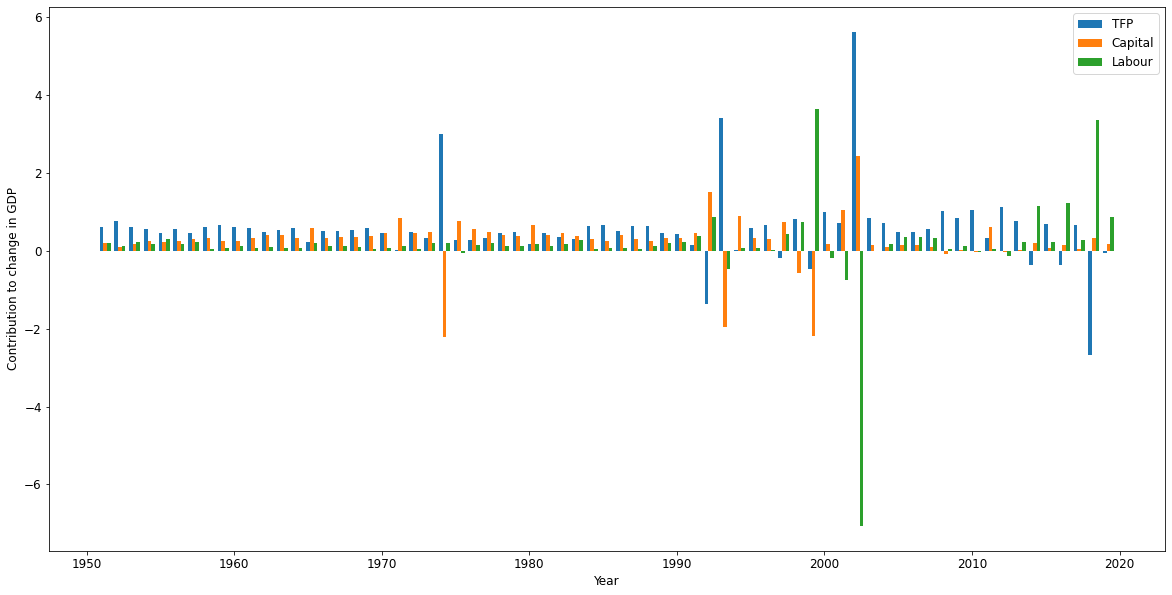

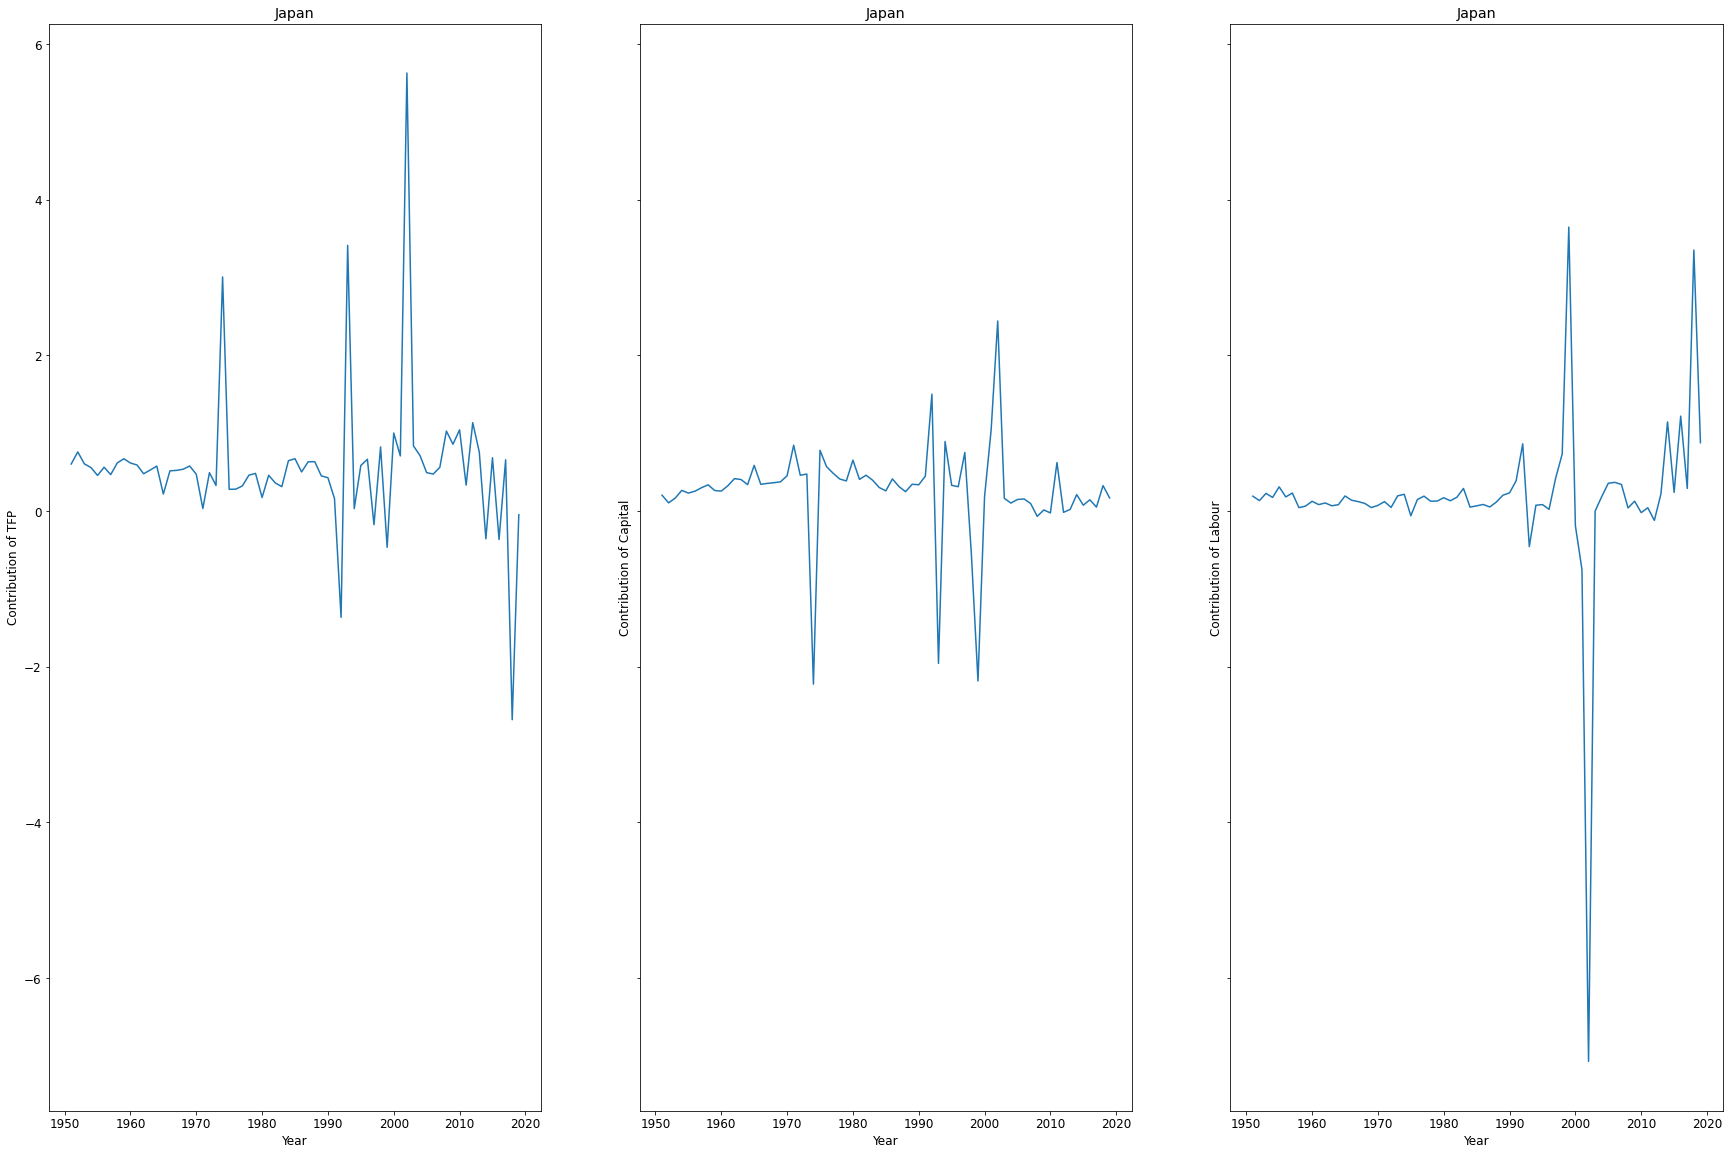

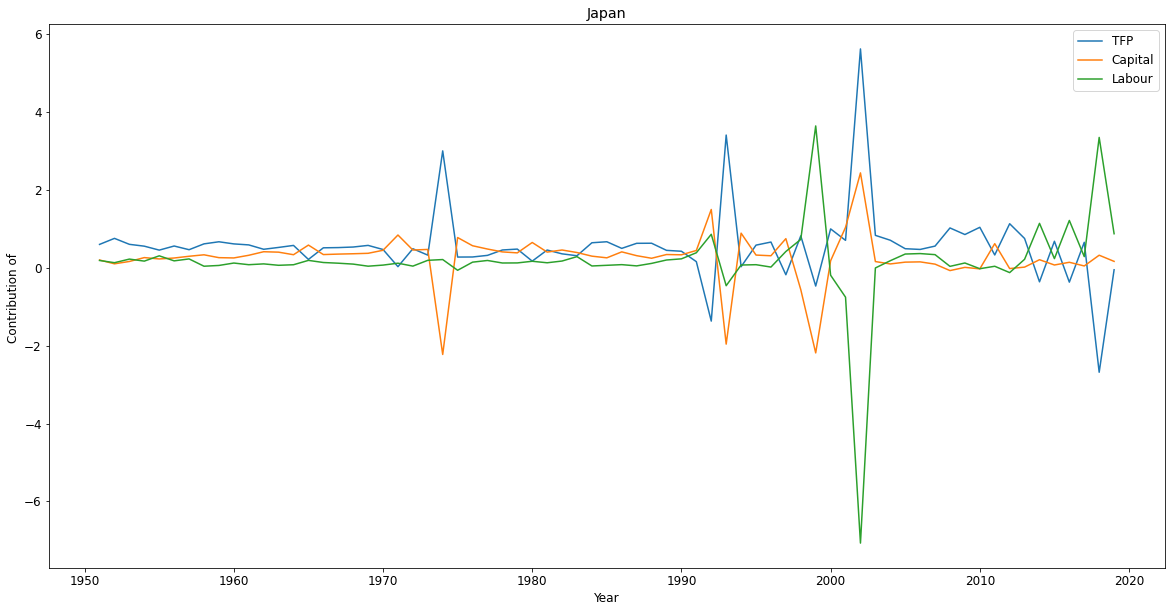

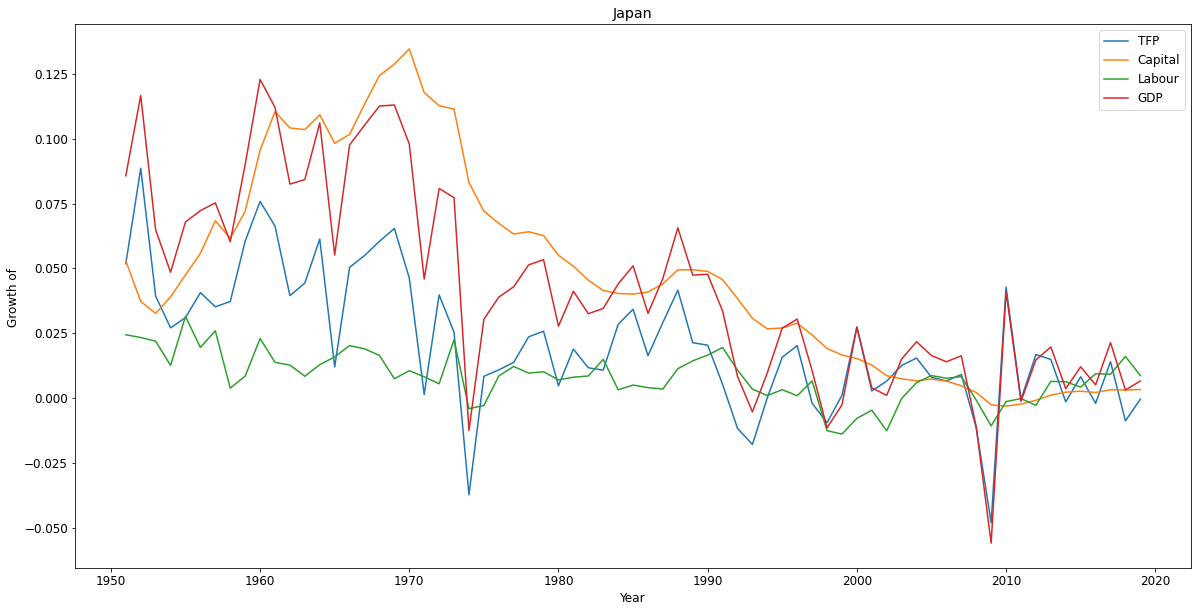

SANITY CHECK that contributions add up to 1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Growth Table
             Year  Growth Y  Growth TFP  Growth K  Growth L  Contribution of TFP  Contribution of K  Contribution of L
Time Period                                                                                                           
1            1951  0.085688    0.051814  0.052923  0.024491             0.604689           0.203817           0.191495
2            1952  0.116567    0.088548  0.037336  0.023430             0.759633           0.105698           0.134669
3            1953  0.064888    0.039351  0.032701  0.022007             0.606456           0.166308           0.227236
4            1954  0.048553    0.027152  0.039072  0.012697             0.559229           0.265562           0.175209
5            1955 

In [12]:
#Run function for growth accounting
find_growth_contribution(data, "Japan", ALPHA)

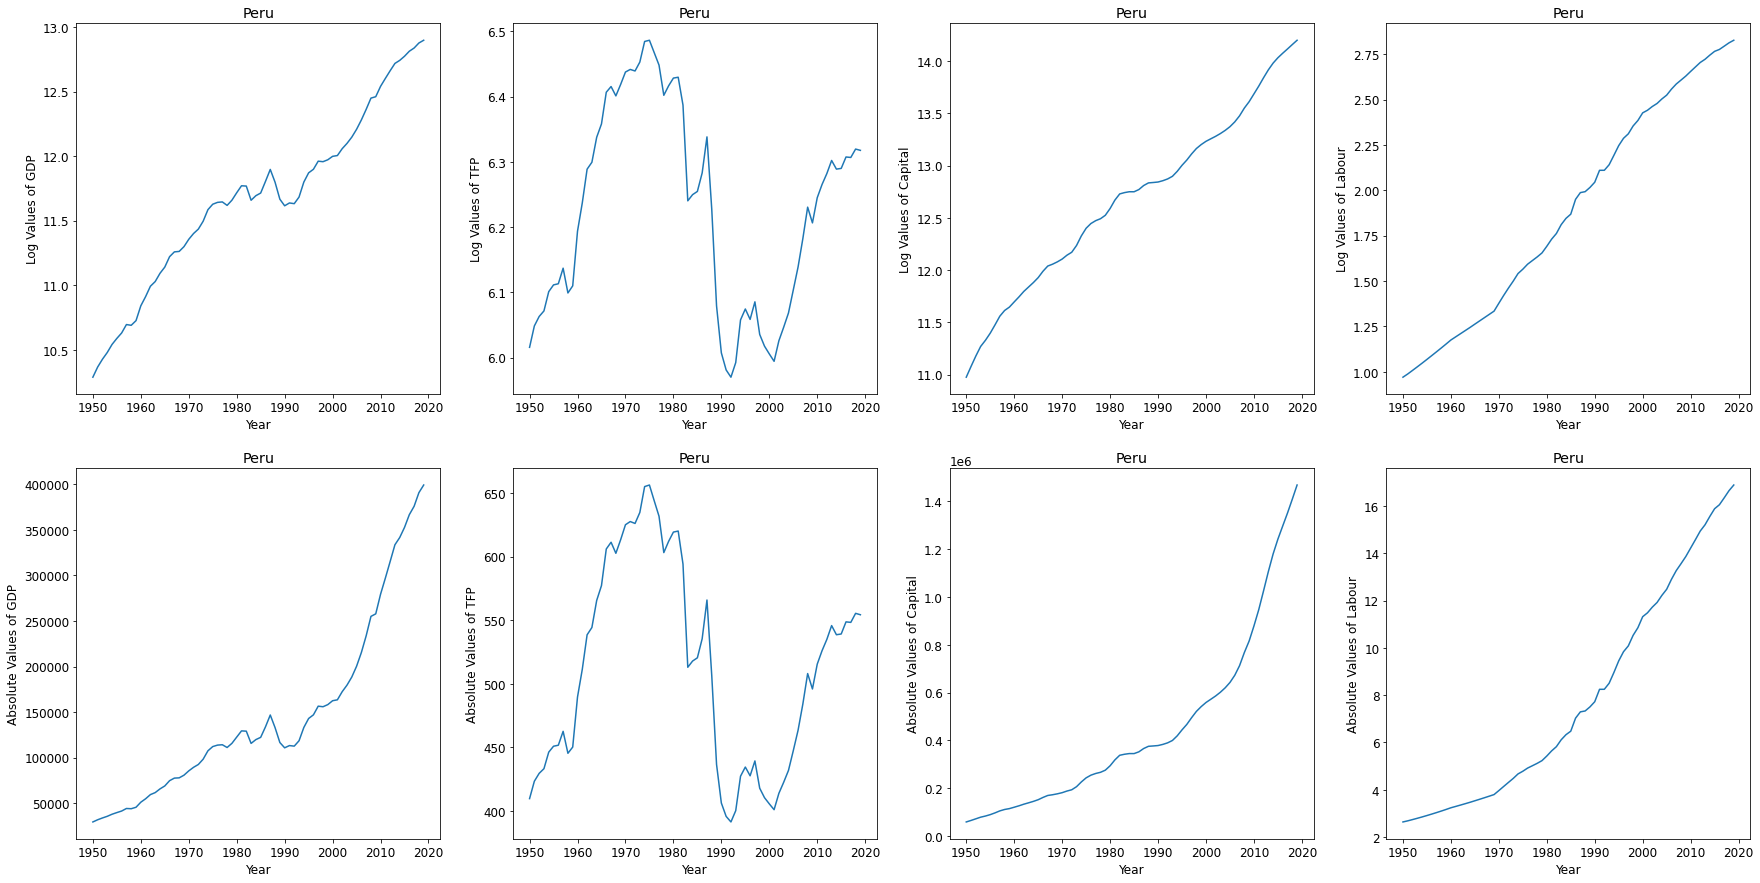

Difference between dataset CTFP and A values calculated
count     66.000000
mean     516.768926
std       79.574264
min      391.062556
25%      445.079615
50%      518.550666
75%      589.134650
max      655.523261
dtype: float64
70


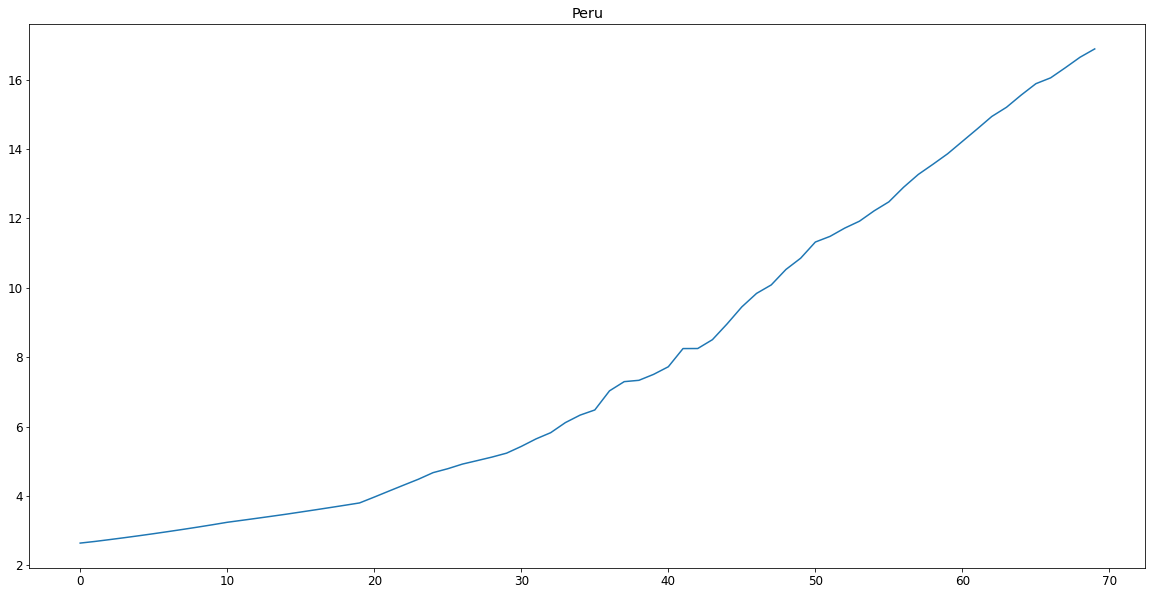

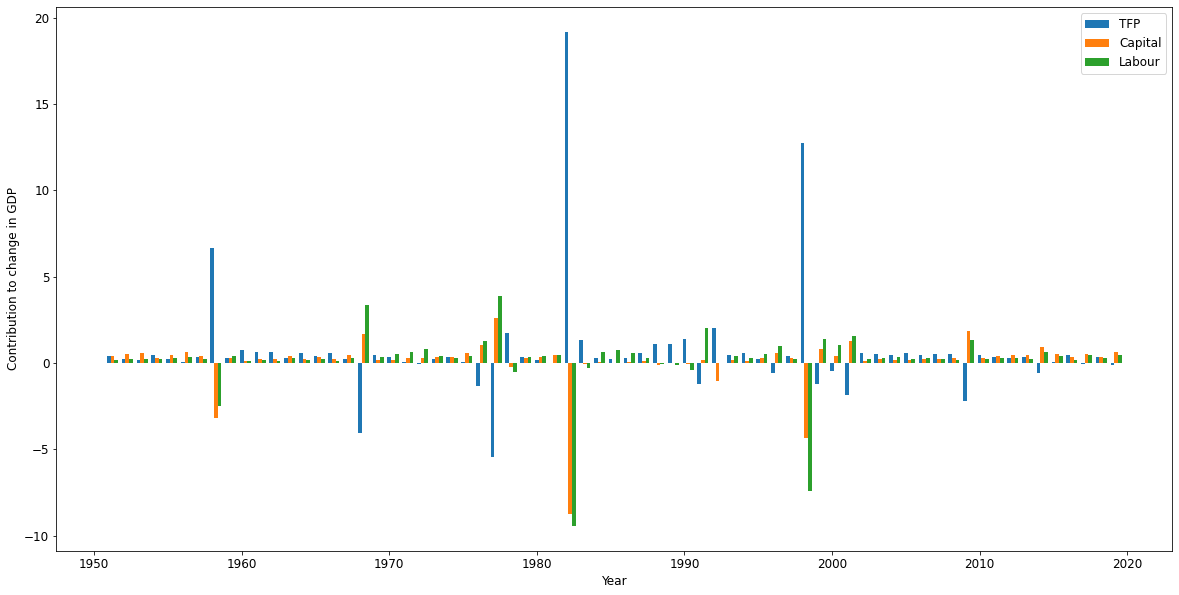

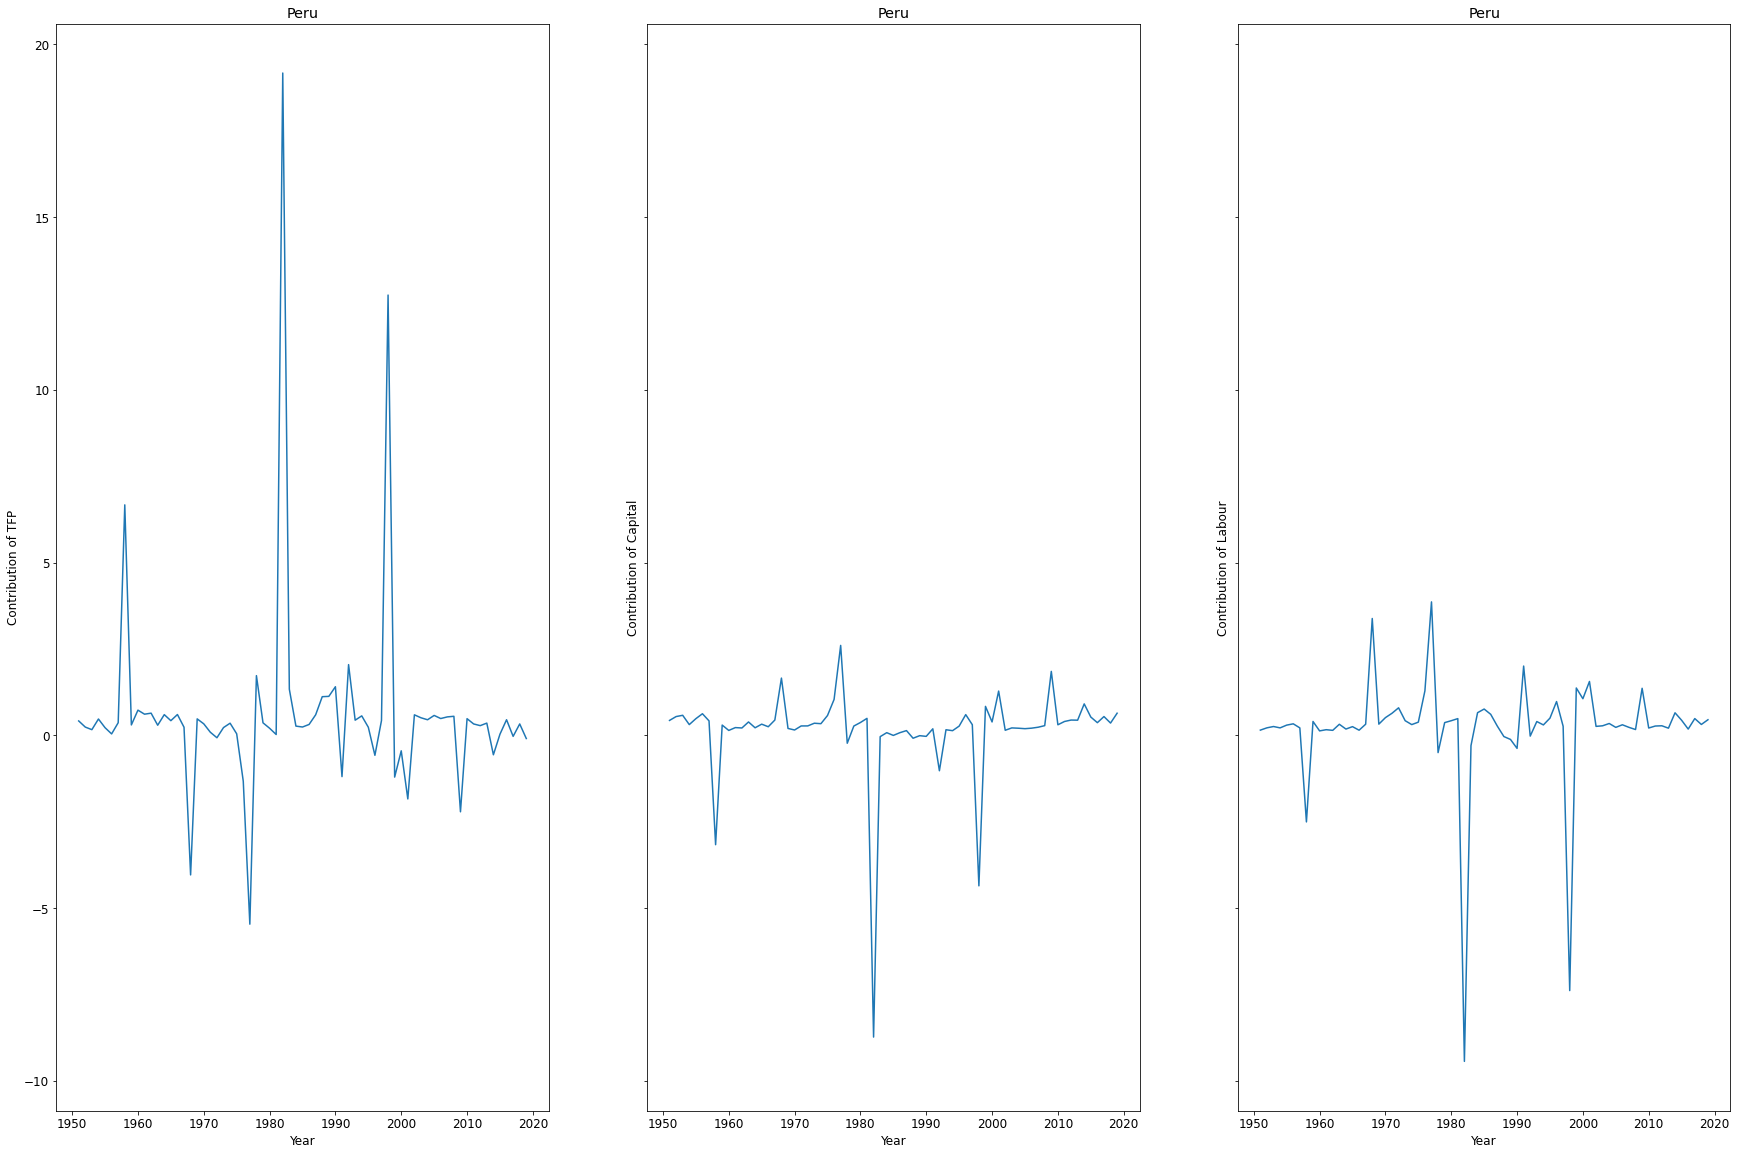

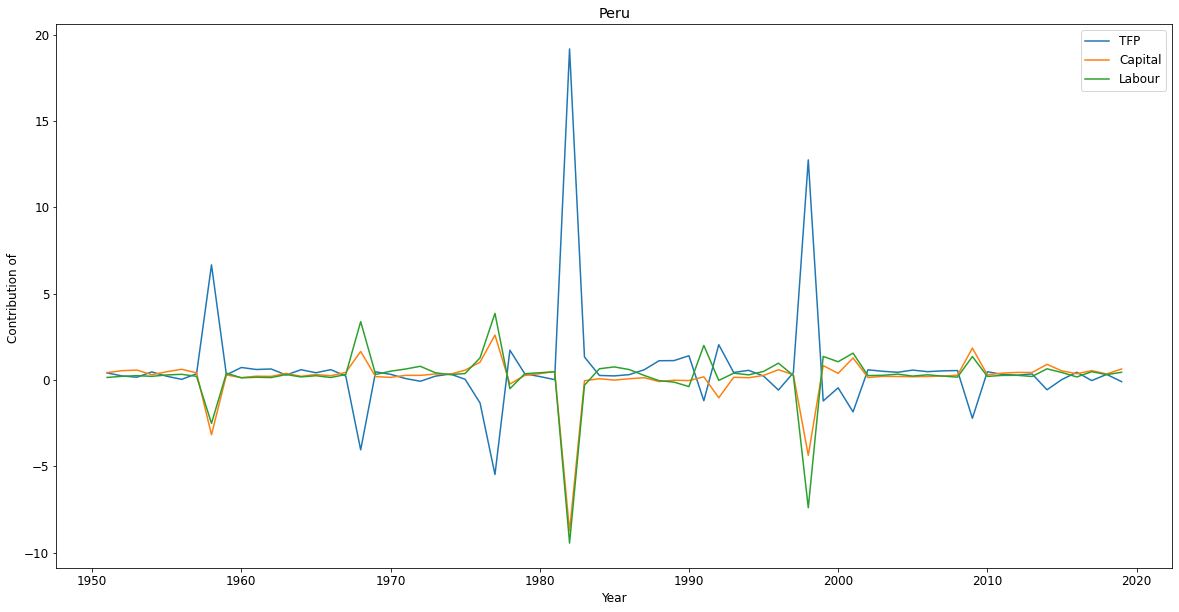

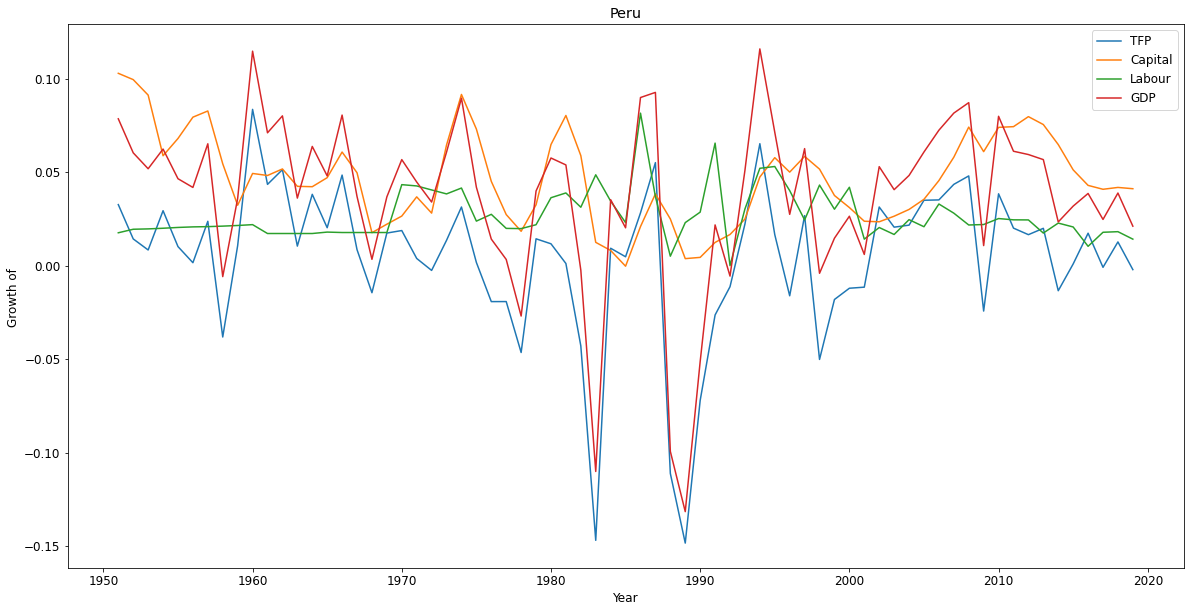

SANITY CHECK that contributions add up to 1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Growth Table
             Year  Growth Y  Growth TFP  Growth K  Growth L  Contribution of TFP  Contribution of K  Contribution of L
Time Period                                                                                                           
1            1951  0.078696    0.032808  0.103026  0.017746             0.416894           0.432022           0.151084
2            1952  0.060506    0.014466  0.099654  0.019633             0.239087           0.543512           0.217401
3            1953  0.051989    0.008550  0.091387  0.019823             0.164463           0.580077           0.255461
4            1954  0.062521    0.029553  0.058954  0.020169             0.472685           0.311173           0.216143
5            1955 

In [13]:
find_growth_contribution(data, "Peru", ALPHA)